In [1]:
import os

data_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))
print(lines[0])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30


In [2]:
import numpy as np

# time is not included
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

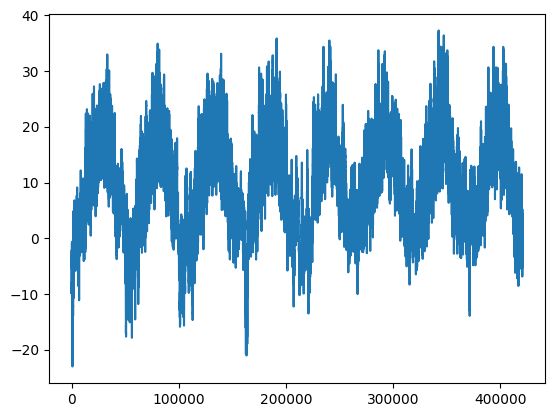

In [3]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

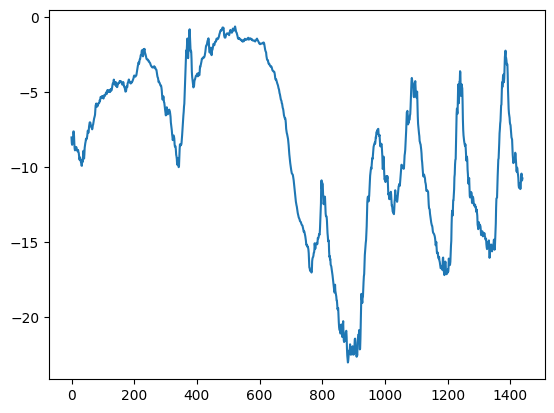

In [9]:
plt.plot(range(1440), temp[:1440])

这次要处理的问题是：给定 `lookback` 个时间点的样本数据，以 `steps` 为粒度进行采样，给出 `delay` 的温度预计。

- `lookback = 720`：使用过去 5 天的观测数据
- `steps = 6`：以每小时进行采样
- `delay = 144`：预测未来一天的数据

下面先对数据进行标准化，因为不同列都是不同维度的数据。标准化方式很简单，对数据进行列处理，减去均值并处以标准差。训练的时候我们只取前 200000 的数据。

In [4]:
num_training_samples = 200000

mean = float_data[:num_training_samples].mean(axis=0)
float_data -= mean
std = float_data[:num_training_samples].std(axis=0)
float_data /= std

In [5]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            # data row with index 1 is temperature
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

num_validation_samples = 100000

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=num_training_samples,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=num_training_samples + 1,
                    max_index=num_training_samples + num_validation_samples,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=num_training_samples + num_validation_samples + 1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = num_validation_samples - 1 - lookback
test_steps = len(float_data) - num_training_samples - num_validation_samples - 1 - lookback

在进行学习之前，需要有一个非学习的基准线。也就是说，先得到一个不需要学习的误差基准，如果学习的效果超过了这个基准，那么学习才是有意义的。比如对于一个分类问题，A 类概率是 90%，B 类概率是 10%，那么对于一个只选择 A 的策略来说，正确率会有 90%，如果学习能超过这个概率，那才是有意义的。

对于这个温度预测的问题，一个比较保守的策略是预测 24 小时候的温度和现在一样。我们先看看这个策略的误差。

In [13]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.28969941979609765


In [7]:
from keras.models import Sequential
from keras import layers
import tensorflow as tf

下面先使用一个简单的两层网络看看效果。

In [14]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(), loss='mae')
basic_dense_network_history = model.fit(train_gen,
                                        steps_per_epoch=500,
                                        epochs=20,
                                        validation_data=val_gen,
                                        validation_steps=500)

Epoch 1/20


2023-10-04 12:02:52.460613: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-04 12:02:52.460633: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-04 12:02:52.460637: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-04 12:02:52.460668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-04 12:02:52.460686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-04 12:02:52.762946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 307s 614ms/step - loss: 3.4081 - val_loss: 1.6540
Epoch 2/20
500/500 [==============================] - 307s 615ms/step - loss: 0.6656 - val_loss: 0.2960
Epoch 3/20
500/500 [==============================] - 294s 588ms/step - loss: 0.3244 - val_loss: 0.3181
Epoch 4/20
500/500 [==============================] - 292s 585ms/step - loss: 0.3211 - val_loss: 0.2867
Epoch 5/20
500/500 [==============================] - 298s 597ms/step - loss: 0.3261 - val_loss: 0.3092
Epoch 6/20
500/500 [==============================] - 294s 589ms/step - loss: 0.3280 - val_loss: 0.3026
Epoch 7/20
500/500 [==============================] - 294s 590ms/step - loss: 0.3297 - val_loss: 0.3431
Epoch 8/20
500/500 [==============================] - 316s 633ms/step - loss: 0.3358 - val_loss: 0.3846
Epoch 9/20
500/500 [==============================] - 318s 636ms/step - loss: 0.3367 - val_loss: 0.4475
Epoch 10/20
500/500 [==============================] - 314s 629ms/step - lo

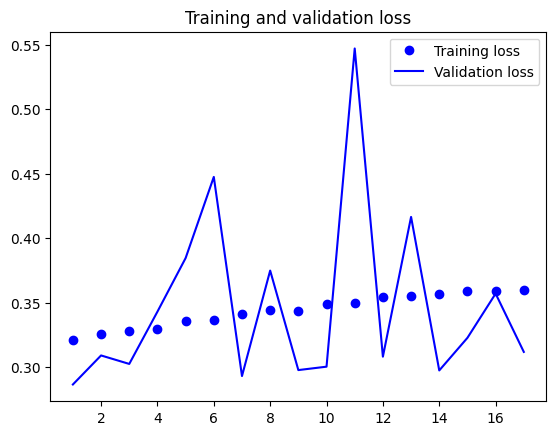

In [20]:
import matplotlib.pyplot as plt

loss = basic_dense_network_history.history['loss']
val_loss = basic_dense_network_history.history['val_loss']

loss = loss[3:]
val_loss = val_loss[3:]

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
model.save_weights('/Users/bifnudozhao/Projects/ai-playground/results/jena_with_2_dense.h5')

In [23]:
model_gru = Sequential()
# model_gru.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model_gru.add(tf.compat.v1.keras.layers.CuDNNGRU(32, input_shape=(None, float_data.shape[-1])))
model_gru.add(layers.Dense(1))

model_gru.compile(optimizer='rmsprop', loss='mae')
gru_history = model_gru.fit(train_gen,
                            steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=500)

Epoch 1/20
500/500 [==============================] - 22s 43ms/step - loss: 0.3022 - val_loss: 0.2671
Epoch 2/20
500/500 [==============================] - 21s 43ms/step - loss: 0.2830 - val_loss: 0.2778
Epoch 3/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2761 - val_loss: 0.2742
Epoch 4/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2725 - val_loss: 0.2541
Epoch 5/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2682 - val_loss: 0.2582
Epoch 6/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2636 - val_loss: 0.2747
Epoch 7/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2597 - val_loss: 0.2588
Epoch 8/20
500/500 [==============================] - 21s 43ms/step - loss: 0.2561 - val_loss: 0.2677
Epoch 9/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2504 - val_loss: 0.2790
Epoch 10/20
500/500 [==============================] - 21s 42ms/step - loss: 0.247

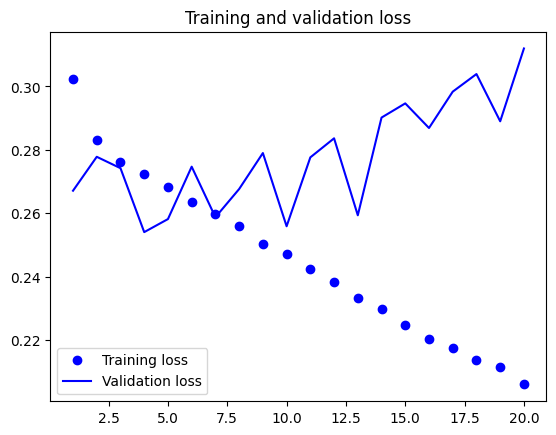

In [24]:
loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:

model_better_gru = Sequential()
model_better_gru.add(tf.keras.layers.GRU(32,
                                dropout=0.1,
                                recurrent_dropout=0.5,
                                return_sequences=True,
                                input_shape=(None, float_data.shape[-1])))
model_better_gru.add(tf.keras.layers.GRU(64, activation='relu',
                                dropout=0.1,
                                recurrent_dropout=0.5))
model_better_gru.add(layers.Dense(1))

model_better_gru.compile(optimizer='rmsprop', loss='mae')
better_gru_history = model_better_gru.fit(train_gen,
                            steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=500)

Epoch 1/20


2023-10-05 11:10:33.115150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  1/500 [..............................] - ETA: 23:18:39 - loss: 0.7498